# Q7 Enhancing Clustering Accuracy with Data Transformation 

## 7.1 Visualizing the data and understanding alterations

### Include necessary libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.optimize import linear_sum_assignment
from sklearn.datasets import fetch_openml
from collections import Counter
from typing import List, Tuple
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

### MNISTVisualizer Class to visualize modified MNIST dataset 

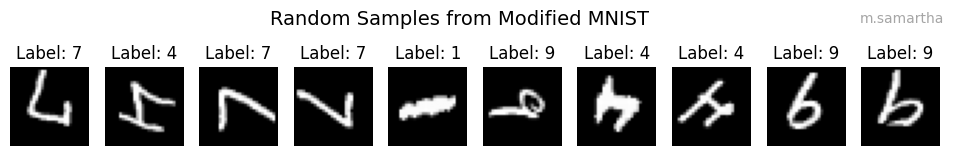

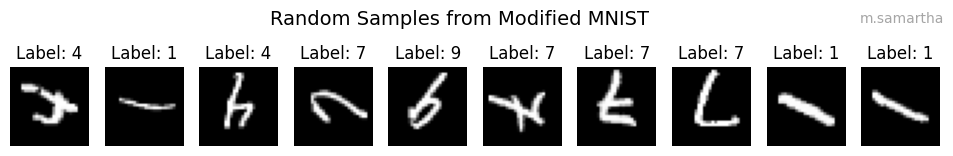

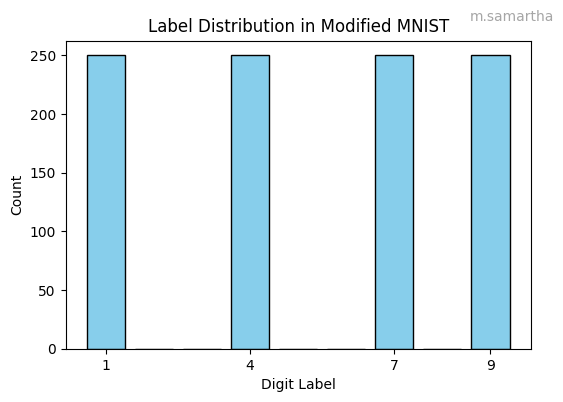

In [47]:
class MNISTVisualizer:
    """
    A class to visualize modified MNIST dataset samples and label distributions.
    """

    def __init__(self, X_path: str, y_path: str):
        """
        Initialize the dataset.

        X_path : str
            Path to the modified MNIST dataset (.npy file).
        y_path : str
            Path to the ground truth labels (.npy file).
        """
        self.X = np.load(X_path)
        self.y = np.load(y_path)

    def show_random_samples(self, n_samples: int = 10):
        """
        Show random samples from the dataset.

        n_samples : int
            Number of random samples to display.
        """
        indices = random.sample(range(len(self.X)), n_samples)

        plt.figure(figsize=(12, 2))
        for i, idx in enumerate(indices):
            plt.subplot(1, n_samples, i + 1)
            plt.imshow(self.X[idx], cmap='gray')
            plt.title(f"Label: {self.y[idx]}")
            plt.axis("off")
        plt.suptitle("Random Samples from Modified MNIST", fontsize=14)
        plt.text(
            1.05, 1.7, "m.samartha",
            ha='right', va='top',
            transform=plt.gca().transAxes,
            fontsize=10, color='gray', alpha=0.7
        )
        plt.show()

    def plot_label_histogram(self):
        """
        Plot a histogram of the digit label distribution.
        """
        plt.figure(figsize=(6, 4))
        plt.hist(self.y, bins=np.arange(min(self.y), max(self.y) + 2) - 0.5,
                 rwidth=0.8, color="skyblue", edgecolor="black")
        plt.xticks(np.unique(self.y))
        plt.xlabel("Digit Label")
        plt.ylabel("Count")
        plt.title("Label Distribution in Modified MNIST")
        plt.text(
            1.05, 1.1, "m.samartha",
            ha='right', va='top',
            transform=plt.gca().transAxes,
            fontsize=10, color='gray', alpha=0.7
        )
        plt.show()

visualizer = MNISTVisualizer("Dataset/Q7/X_modified.npy", "Dataset/Q7/y_true.npy")
visualizer.show_random_samples(n_samples=10)
visualizer.show_random_samples(n_samples=10)
visualizer.plot_label_histogram()

### Observations from visualizations
From the histogram plot, we can observe that the dataset only contains digits 1, 4, 7 and 9 with 250 samples of each. From the visualization of random samples, we can see that the digits have been altered by rotating them with multiples of 90 degrees. This alteration can significantly affect the performance of clustering algorithms, as they may not recognize rotated versions of the same digit as belonging to the same cluster.

## 7.2 Suitable Transformation Technique

PCA can be used here as a transformation and is effective because it reduces dimensionality while preserving key variance in digit structures, removing noise from rotated pixels. By projecting images onto principal components, PCA emphasizes shape-based features over orientation, making rotated versions of the same digit more similar and thus improving clustering robustness and accuracy.

In comparison to applying clustering algorithms like K-mean without reducing dimensions through PCA, PCA helps us in grouping images by intrinsic shape rather than their orientation, leading to more accurate clustering results.

It also makes the computation more efficient by reducing the number of features, which is particularly beneficial when dealing with high-dimensional image data.

In [48]:
class PCA:
    """
    Custom Implementation of Principal Component Analysis (PCA).

    n_components : int
        Number of principal components to keep.
    """

    def __init__(self, n_components: int):
        """
        Initialize PCA with the desired number of components.

        n_components : int
            The number of dimensions to reduce the data to.
        """
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance = None

    def fit(self, X: np.ndarray):
        """
        Fit the PCA model to the dataset by computing principal components.

        X : np.ndarray, shape (n_samples, n_features)
            The dataset to fit.

        Returns
        -------
        self : PCA
            Fitted PCA model.
        """
        # Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Compute covariance matrix
        cov_matrix = np.cov(X_centered, rowvar=False)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Sort eigenvalues (descending) and corresponding eigenvectors
        sorted_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_idx]
        eigenvectors = eigenvectors[:, sorted_idx]

        # Keep only the top n_components
        self.explained_variance = eigenvalues[:self.n_components]
        self.components = eigenvectors[:, :self.n_components]

        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Transform the dataset into the reduced dimension space.

        X : np.ndarray, shape (n_samples, n_features)
            The dataset to transform.

        Returns
        -------
        X_transformed : np.ndarray, shape (n_samples, n_components)
            Transformed dataset with reduced dimensions.
        """
        if self.mean is None or self.components is None:
            raise RuntimeError("PCA model has not been fitted yet. Call fit() before transform().")

        X_centered = X - self.mean
        X_transformed = np.dot(X_centered, self.components)

        return X_transformed

    def checkPCA(self, X: np.ndarray) -> bool:
        """
        Check if PCA reduces the dataset to the required dimensions.

        X : np.ndarray, shape (n_samples, n_features)
            Dataset to check PCA on.

        Returns
        -------
        result : bool
            True if PCA reduces dimensions correctly, False otherwise.
        """
        transformed = self.transform(X)
        return transformed.shape[1] == self.n_components

### K-Means Class

In [49]:
class KMeans:
    """
    n_clusters : int
        The number of clusters to form.
    max_iters : int
        Maximum number of iterations of the K-Means algorithm.
    centroids : np.ndarray
        The coordinates of the cluster centers.
    """

    def __init__(self, n_clusters: int = 3, max_iters: int = 100):
        """
        Initialize the KMeans object with the number of clusters and iterations.

        n_clusters : int, optio
            The number of clusters to form (default is 3).
        max_iters : int, optional
            Maximum number of iterations of the K-Means algorithm (default is 100).
        """
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.centroids = None

    def fit(self, X: np.ndarray):
        if isinstance(X, pd.DataFrame):
            X = X.values.astype(np.float32)

        np.random.seed(69)
        random_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_indices].astype(np.float32)

        for _ in range(self.max_iters):
            labels = self.predict(X)

            new_centroids = []
            for i in range(self.n_clusters):
                cluster_points = X[labels == i]
                if len(cluster_points) > 0:
                    centroid = cluster_points.mean(axis=0)
                else:
                    # Reinitialize empty cluster
                    centroid = X[np.random.randint(0, X.shape[0])]
                new_centroids.append(centroid)

            new_centroids = np.array(new_centroids, dtype=np.float32)

            if self.centroids.shape == new_centroids.shape and np.allclose(self.centroids, new_centroids, atol=1e-6):
                break

            self.centroids = new_centroids

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the closest cluster each sample in X belongs to.

        X : np.ndarray
            New data to predict of shape (n_samples, n_features).

        Returns
        labels : np.ndarray
            Index of the cluster each sample belongs to.

        """
        if isinstance(X, pd.DataFrame):
            X = X.values
            
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        # print(distances)
        return np.argmin(distances, axis=1)

    def getCost(self, X: np.ndarray) -> float:
        """
        Compute the Within-Cluster Sum of Squares (WCSS).

        X : np.ndarray
            The input data of shape (n_samples, n_features).

        Returns
        cost : float
            The WCSS value.
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
            
        labels = self.predict(X)
        cost = 0.0
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            cost += np.sum((cluster_points - self.centroids[i]) ** 2)
        return cost

## 7.3 Compairson of clustering performance with and without PCA

### PCA_KMeans Class

In [50]:
class PCA_KMeans:
    """
    Wrapper class to apply PCA and K-Means clustering on MNIST dataset
    and evaluate clustering performance using purity.
    """
    def __init__(self, X_path: str = "Dataset/Q7/X_modified.npy", y_path: str = "Dataset/Q7/y_true.npy"):
        """
        Initialize PCA_KMeans object. Loads dataset from .npy files.

        X_path : str
            Path to the features .npy file.
        y_path : str
            Path to the labels .npy file.
        """
        print(f"Loading dataset from {X_path} and {y_path} ...")
        self.X = np.load(X_path).astype(np.float32)
        self.y = np.load(y_path).astype(int)
        print(f"Dataset loaded: {self.X.shape[0]} samples, {self.X.shape[1]} features.")

        # Flatten if needed
        if len(self.X.shape) > 2:
            n_samples = self.X.shape[0]
            self.X = self.X.reshape(n_samples, -1)

    def compute_purity(self, labels: np.ndarray, y_true: np.ndarray) -> float:
        """
        Compute clustering purity.

        labels : np.ndarray
            Predicted cluster labels.
        y_true : np.ndarray
            Ground truth class labels.

        Returns
        -------
        purity : float
            Mean cluster purity.
        """
        clusters = np.unique(labels)
        purities = []
        for c in clusters:
            cluster_points = y_true[labels == c]
            if len(cluster_points) > 0:
                most_common = Counter(cluster_points).most_common(1)[0][1]
                purities.append(most_common / len(cluster_points))
        return np.mean(purities)

    def clustering_direct(self, k_values: List[int]):
        """
        Perform K-Means clustering directly on raw MNIST and plot purity vs. K.

        k_values : list of int
            List of K values to test.
        """
        purities = []
        for k in k_values:
            print(f"Clustering with K={k}")
            kmeans = KMeans(n_clusters=k, max_iters=100)
            kmeans.fit(self.X)
            labels = kmeans.predict(self.X)
            purity = self.compute_purity(labels, self.y)
            purities.append(purity)
        print("\n")
        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(k_values, purities, marker="o", linestyle="-", label="Direct K-Means")
        plt.xlabel("Number of Clusters (K)")
        plt.ylabel("Purity")
        plt.title("Purity vs. K (Direct K-Means on MNIST)")
        plt.legend()
        plt.grid(True)
        plt.show()

    def clustering_with_pca(self, n_components_list: List[int], k_values: List[int]):
        """
        Perform PCA first, then K-Means clustering, and plot purity vs. n_components for each K.

        n_components_list : list of int
            List of PCA dimensions to test.
        k_values : list of int
            List of K values to test.
        """
        results = {}

        for k in k_values:
            purities = []
            print(f"Running PCA + KMeans with K={k}")
            for n_components in n_components_list:
                pca = PCA(n_components=n_components)
                pca.fit(self.X)
                X_reduced = pca.transform(self.X)

                kmeans = KMeans(n_clusters=k, max_iters=100)
                kmeans.fit(X_reduced)
                labels = kmeans.predict(X_reduced)

                purity = self.compute_purity(labels, self.y)
                purities.append(purity)

            results[k] = purities

        # Plot results
        plt.figure(figsize=(10, 6))
        for k, purities in results.items():
            plt.plot(n_components_list, purities, marker="o", linestyle="-", label=f"K={k}")
        plt.xlabel("Number of PCA Components")
        plt.ylabel("Purity")
        plt.title("Purity vs. PCA Components for Different K")
        plt.legend()
        plt.grid(True)
        plt.show()

Loading dataset from Dataset/Q7/X_modified.npy and Dataset/Q7/y_true.npy ...
Dataset loaded: 1000 samples, 28 features.
Clustering with K=10
Clustering with K=20
Clustering with K=30
Clustering with K=50
Clustering with K=75
Clustering with K=100
Clustering with K=125
Clustering with K=150
Clustering with K=175
Clustering with K=200
Clustering with K=250
Clustering with K=300
Clustering with K=400
Clustering with K=500




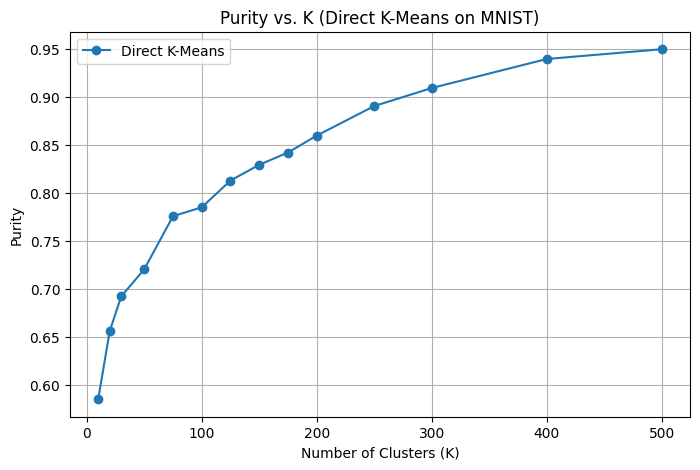

Running PCA + KMeans with K=10
Running PCA + KMeans with K=20
Running PCA + KMeans with K=30
Running PCA + KMeans with K=50
Running PCA + KMeans with K=75
Running PCA + KMeans with K=100
Running PCA + KMeans with K=150
Running PCA + KMeans with K=200
Running PCA + KMeans with K=250
Running PCA + KMeans with K=500


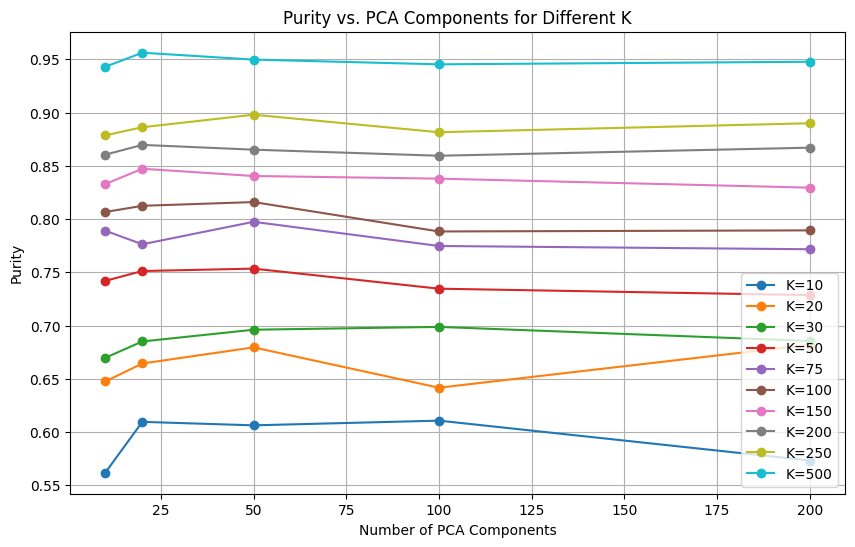

In [51]:
# Initialize
pca_kmeans = PCA_KMeans()

# 1. Clustering directly with K-Means
k_values = [10, 20, 30, 50, 75, 100, 125, 150, 175, 200, 250, 300, 400, 500] 
pca_kmeans.clustering_direct(k_values)

# 2. Clustering with PCA first
n_components_list = [10, 20, 50, 100, 200]
k_values = [10, 20, 30, 50, 75, 100, 150, 200, 250, 500] 
pca_kmeans.clustering_with_pca(n_components_list, k_values)

### Observations from the Purity Plots
We see that the purity scores for K-Means clustering increase with K, which is expected as more clusters allow for finer distinctions. 

When using PCA before K-Means, we observe that purity scores are generally increasing until n_components = 50 and then plateauing, indicating that reducing dimensions to around **50 captures most of the relevant variance for clustering**. Beyond this point, additional components do not significantly enhance clustering performance, suggesting that the essential features for distinguishing the digits are retained within the first 50 principal components.

### Choosing the optimal K-value for K-Means

#### Elbow Method

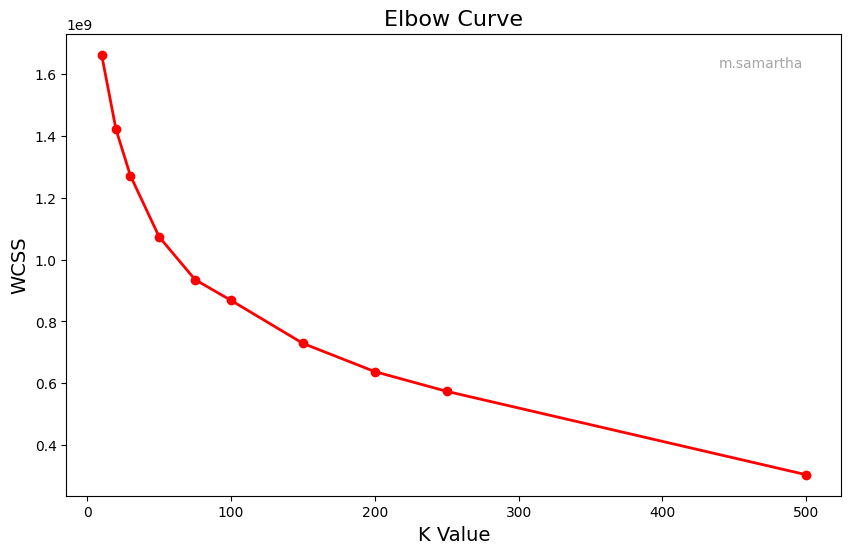

In [52]:
# Plot Elbow Curve (WCSS vs K)
X_path = "Dataset/Q7/X_modified.npy"
y_path = "Dataset/Q7/y_true.npy"

X = np.load(X_path).astype(np.float32)
y = np.load(y_path).astype(int)

# Flatten if needed
if len(X.shape) > 2:
    n_samples = X.shape[0]
    X = X.reshape(n_samples, -1)

k_values = [10, 20, 30, 50, 75, 100, 150, 200, 250, 500] 
wcss = []
n_components = 50
for num_clusters in k_values:
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X_reduced = pca.transform(X)

    kmeans = KMeans(n_clusters=num_clusters, max_iters=100)
    kmeans.fit(X_reduced)
    wcss.append(kmeans.getCost(X_reduced))

plt.figure(figsize=(10,6))
plt.plot(k_values, wcss, linewidth=2, color="red", marker ="o")
plt.title("Elbow Curve", fontsize=16)
plt.xlabel("K Value", fontsize=14)
plt.ylabel("WCSS", fontsize=14)

plt.text(
    0.95, 0.95, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
plt.show()

#### Silhoutte Method

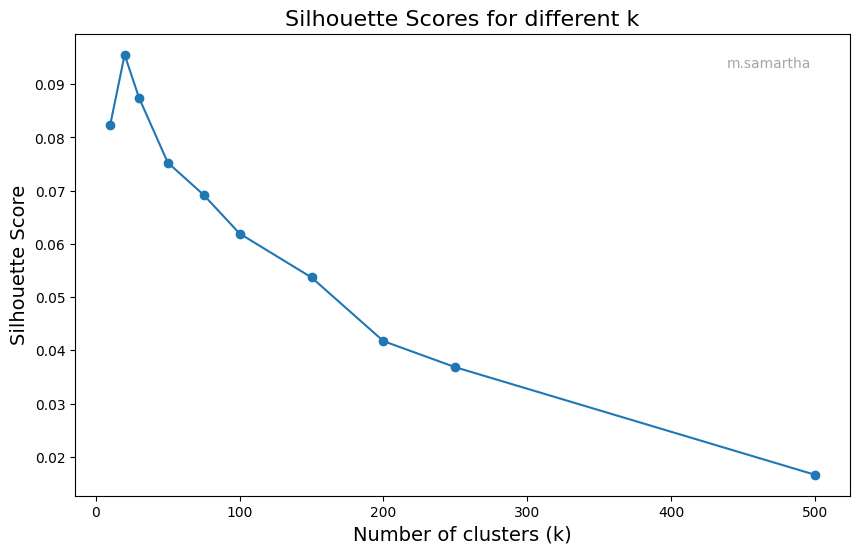

In [53]:
sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, max_iters=100)
    kmeans.fit(X)
    labels = kmeans.predict(X)

    score = silhouette_score(X, labels)
    sil_scores.append(score)

plt.figure(figsize=(10,6))
plt.plot(k_values, sil_scores, marker='o')
plt.title("Silhouette Scores for different k", fontsize=16)
plt.xlabel("Number of clusters (k)", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.text(
    0.95, 0.95, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
plt.show()

### Observations for choosing optimal K
From the Elbow method, we see that the WCCS is monotonically decreasing and we don't get an "elbow" point. But from the Silhouette method, we see that the silhouette score peaks at K=20. Therefore, we choose K=20 as the optimal number of clusters for K-Means clustering.

## 7.4 ARI/NMI Scores comparison and conclusion

For clustering after PCA is applied, we choose K = 20 (optimal K from silhouette method) and analyse the behaviour of ARI and NMI scores as we vary the number of principal components.

ARI (Adjusted Rand Index) is a measure of the similarity between two data clusterings, adjusted for chance grouping. It ranges from -1 to 1, where 1 indicates perfect agreement between the predicted and true labels, 0 indicates random labeling, and negative values indicate less agreement than expected by chance.

NMI (Normalized Mutual Information) measures the amount of information shared between the predicted and true labels, normalized to account for the size of the clusters. It ranges from 0 to 1, where 1 indicates perfect correlation and 0 indicates no correlation.

### K_Means_Data_Transform Class

In [54]:
class K_Means_Data_Transform:
    """
    A class to analyze clustering accuracy on modified MNIST data,
    apply transformations, and compare results.
    """

    def __init__(self, X_path: str, y_path: str, k_values: np.ndarray, n_components_list: np.ndarray):
        """
        Initialize dataset.

        X_path : str
            Path to the modified MNIST dataset (.npy file).
        y_path : str
            Path to the ground truth labels (.npy file).
        """
        self.X = np.load(X_path)
        self.y = np.load(y_path)
        self.X_flat = self.X.reshape(len(self.X), -1)  # Flatten images
        self.k_values = k_values
        self.n_components_list = n_components_list

    def clustering(self):
        """
        Perform clustering and evaluate results.

        X_input : np.ndarray
            Feature matrix for clustering.
        description : str
            Label for describing current experiment.

        Returns
        -------
        dict
            Dictionary with clustering metrics.
        """
        
        nmi_score, ari_score = [], []
        for k in self.k_values:
            kmeans = KMeans(n_clusters=k, max_iters=100)
            kmeans.fit(self.X_flat)
            preds = kmeans.predict(self.X_flat)

            nmi = normalized_mutual_info_score(self.y, preds)
            ari = adjusted_rand_score(self.y, preds)

            nmi_score.append(nmi)
            ari_score.append(ari)

        # Visualize results
        plt.figure(figsize=(10, 6))
        plt.plot(self.k_values, nmi_score, marker='o', label='NMI')
        plt.plot(self.k_values, ari_score, marker='s', label='ARI')
        plt.title(f"Clustering Metrics on Without Transformation Data", fontsize=16)
        plt.xlabel("Number of Clusters (K)", fontsize=14)
        plt.ylabel("Score", fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

    def clustering_with_pca(self):
        """
        Perform PCA first, then K-Means clustering, and plot purity vs. n_components for each K.
        """
        results_nmi = {}
        results_ari = {}
        for k in self.k_values:
            nmi_score, ari_score = [], []
            for n_components in self.n_components_list:
                # Centre the data
                X_centred = self.X_flat - np.mean(self.X_flat, axis=0)
                pca = PCA(n_components=n_components)
                pca.fit(X_centred)
                X_reduced = pca.transform(X_centred)

                kmeans = KMeans(n_clusters=k, max_iters=100)
                kmeans.fit(X_reduced)
                labels = kmeans.predict(X_reduced)

                nmi = normalized_mutual_info_score(self.y, labels)
                ari = adjusted_rand_score(self.y, labels)
                nmi_score.append(nmi)
                ari_score.append(ari)

            results_nmi[k] = nmi_score 
            results_ari[k] = ari_score

        # Plot NMI results
        plt.figure(figsize=(10, 6))
        for k, nmi_scores in results_nmi.items():
            plt.plot(self.n_components_list, nmi_scores, marker="o", linestyle="-", label=f"K={k} (NMI)")
        plt.xlabel("Number of PCA Components", fontsize=14)
        plt.ylabel("NMI Score", fontsize=14)
        plt.title("NMI vs. PCA Components for Different K", fontsize=16)
        plt.legend()
        plt.grid(True)
        plt.text(
            0.95, 0.95, "m.samartha",
            ha='right', va='top',
            transform=plt.gca().transAxes,
            fontsize=10, color='gray', alpha=0.7
        )
        plt.show()

        # Plot ARI results
        plt.figure(figsize=(10, 6))
        for k, ari_scores in results_ari.items():
            plt.plot(self.n_components_list, ari_scores, marker="s", linestyle="--", label=f"K={k} (ARI)")
        plt.xlabel("Number of PCA Components", fontsize=14)
        plt.ylabel("ARI Score", fontsize=14)
        plt.title("ARI vs. PCA Components for Different K", fontsize=16)
        plt.legend()
        plt.grid(True)
        plt.text(
            0.97, 0.99, "m.samartha",
            ha='right', va='top',
            transform=plt.gca().transAxes,
            fontsize=10, color='gray', alpha=0.7
        )
        plt.show()


Running KMeans on Without Transformation data...


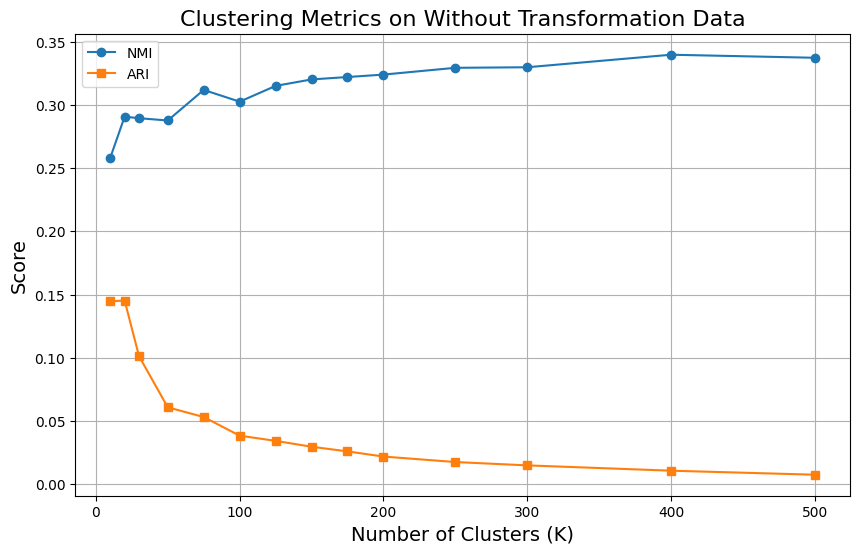


Running KMeans on With PCA Transformation data...


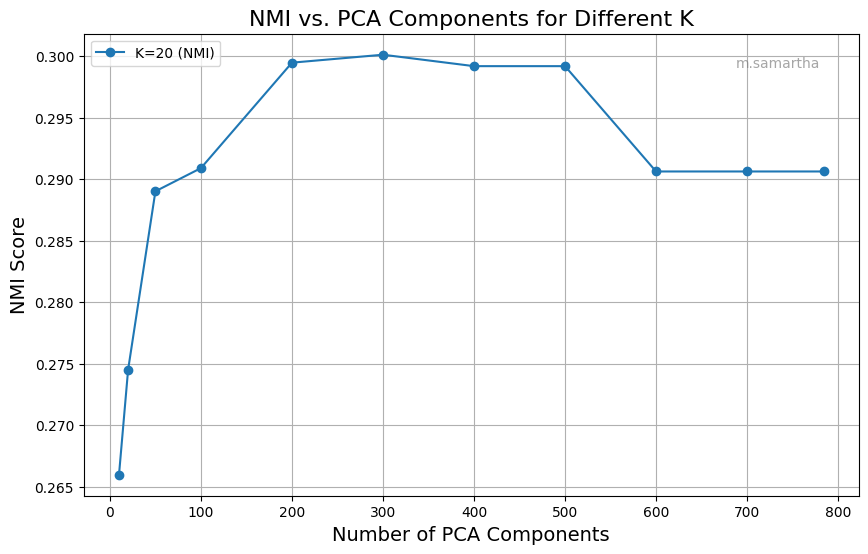

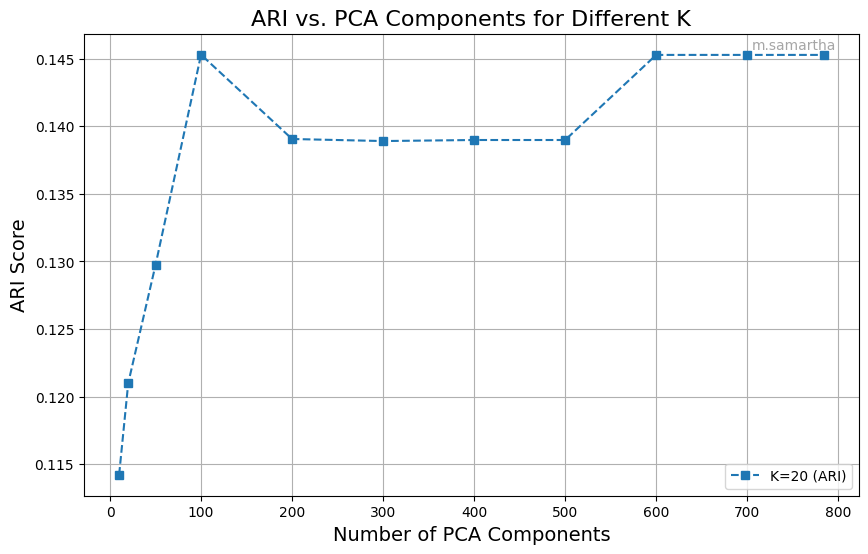

In [55]:
# Analysis and comparison
k_values = [10, 20, 30, 50, 75, 100, 125, 150, 175, 200, 250, 300, 400, 500] 
n_components_list = [10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 784]
pca_kmeans = K_Means_Data_Transform("Dataset/Q7/X_modified.npy", "Dataset/Q7/y_true.npy", k_values, n_components_list)

# Cluster before transformation
print(f"\nRunning KMeans on Without Transformation data...")
pca_kmeans.clustering()

k_values = [20]
pca_kmeans = K_Means_Data_Transform("Dataset/Q7/X_modified.npy", "Dataset/Q7/y_true.npy", k_values, n_components_list)

# Cluster after PCA transformation
print(f"\nRunning KMeans on With PCA Transformation data...")
pca_kmeans.clustering_with_pca()

### Observations and Conclusion
From the plots, we observe that both NMI and ARI scores are not reduced when PCA is applied and even provide a slight improvement in clustering performance. This indicates that PCA effectively captures the essential features of the data while reducing noise and irrelevant variations caused by rotations. 

The PCA transformation helps in grouping similar digits together more accurately, as it emphasizes shape-based features over orientation. This helps the rotated versions of the same digit to be recognized as belonging to the same cluster, leading to improved clustering metrics with lesser features, which is also computationally efficient. 